1. Importing Libraries

In [1]:
#Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

2. Load And Explore

In [2]:
#Load the dataset from a CSV file into a DataFrame
data = pd.read_csv('A2_dataset.csv', low_memory=False) #Set low_memory=False to avoid warning about mixed data types

#Explore the dataset
print(data.info()) #Display information about data types and non-null counts
print(data.head()) #Show the first few rows of the dataset for an initial look
print(data.describe()) #Get descriptive statistics for numerical columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27496 entries, 0 to 27495
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  27496 non-null  int64  
 1   supportedDevices                    7818 non-null   object 
 2   features                            7818 non-null   object 
 3   advisories                          7818 non-null   object 
 4   isGameCenterEnabled                 7818 non-null   object 
 5   screenshotUrls                      27496 non-null  object 
 6   ipadScreenshotUrls                  7818 non-null   object 
 7   appletvScreenshotUrls               7818 non-null   object 
 8   artworkUrl60                        27496 non-null  object 
 9   artworkUrl512                       27496 non-null  object 
 10  artworkUrl100                       27496 non-null  object 
 11  artistViewUrl                       27451

3. Data Cleaning

In [3]:
#Remove rows with missing 'id' values as each app should have a unique identifier
data.dropna(subset=['id'], inplace=True)

#Remove any duplicate entries based on 'id' since they are not useful for analysis
data.drop_duplicates(subset=['id'], inplace=True)

#Convert 'price' column to numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce') #Set errors='coerce' to handle any errors during conversion


#Handle outliers by capping extreme values in the 'price' column
for col in ['price']:
    lower_bound = data[col].quantile(0.01)  #1st percentile
    upper_bound = data[col].quantile(0.99)  #99th percentile
    data[col] = np.clip(data[col], lower_bound, upper_bound)  #Clip values to these bounds

#Calculate IQR for 'price'
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

#Remove outliers beyond 1.25*IQR
data = data[(data['price'] >= (Q1 - 1.25 * IQR)) & (data['price'] <= (Q3 + 1.25 * IQR))]


#Setting any negative prices to zero although im not sure why prices are below zero in the first place
data.loc[data['price'] < 0, 'price'] = 0

#Categorize apps as 'Free' or 'Paid' based on their price
data['price_category'] = data['price'].apply(lambda x: 'Free' if x == 0 else 'Paid')

#Drop rows with any remaining NA values; this ensures that analysis is on complete data
data.dropna(inplace=True)


4. Descriptive Stats For Numerical Columns

In [4]:
#List of numerical columns to analyze
numeric_cols = ['price', 'fileSizeBytes', 'averageUserRatingForCurrentVersion', 'averageUserRating', 'userRatingCount']
for col in numeric_cols:
    #Calculate and print descriptive statistics for each numerical column
    print(f"Statistics for column: {col}")
    print(f"Mean: {data[col].mean()}")
    print(f"Median: {data[col].median()}")
    
    #Calculate mode
    mode_value = data[col].mode()
    print(f"Mode: {mode_value[0] if not mode_value.empty else 'N/A'}")
    
    print(f"Standard Deviation: {data[col].std()}")
    print('-' * 50)


Statistics for column: price
Mean: 0.7510532572515455
Median: 0.0
Mode: 0.0
Standard Deviation: 1.6713851820127203
--------------------------------------------------
Statistics for column: fileSizeBytes
Mean: 101895294.93271516
Median: 33977856.0
Mode: 722944
Standard Deviation: 248658284.6505312
--------------------------------------------------
Statistics for column: averageUserRatingForCurrentVersion
Mean: 2.9436965406562052
Median: 4.2
Mode: 0.0
Standard Deviation: 2.1403661737392223
--------------------------------------------------
Statistics for column: averageUserRating
Mean: 2.9436965406562052
Median: 4.2
Mode: 0.0
Standard Deviation: 2.1403661737392223
--------------------------------------------------
Statistics for column: userRatingCount
Mean: 2439.7472658107467
Median: 3.0
Mode: 0
Standard Deviation: 43524.108381306505
--------------------------------------------------


5. Category Analysis

In [5]:
#List of categorical columns
categorical_cols = ['genres', 'primaryGenreName', 'releaseDate', 'currency', 'contentAdvisoryRating']
for col in categorical_cols:
    #Print the number of unique values and the top 5 most frequent values
    print(f"Statistics for column: {col}")
    print(f"Number of unique values: {data[col].nunique()}")
    print(f"Top 5 values:\n{data[col].value_counts().head()}")
    print('-' * 50)


Statistics for column: genres
Number of unique values: 693
Top 5 values:
genres
['Utilities', 'Productivity']    252
['Productivity', 'Utilities']    242
['Education']                    169
['Utilities']                    126
['Business', 'Productivity']      85
Name: count, dtype: int64
--------------------------------------------------
Statistics for column: primaryGenreName
Number of unique values: 25
Top 5 values:
primaryGenreName
Utilities       625
Education       574
Productivity    567
Games           567
Music           225
Name: count, dtype: int64
--------------------------------------------------
Statistics for column: releaseDate
Number of unique values: 2657
Top 5 values:
releaseDate
2020-09-16T07:00:00Z    13
2023-09-18T07:00:00Z    12
2020-03-20T07:00:00Z    11
2022-01-26T08:00:00Z    10
2020-07-30T07:00:00Z     9
Name: count, dtype: int64
--------------------------------------------------
Statistics for column: currency
Number of unique values: 1
Top 5 values:
curren

6. User Ratings Analysis

In [6]:
#Using a matrix to simplify correlations between multiple columns
correlation_matrix = data[['averageUserRating', 'price', 'fileSizeBytes', 'userRatingCount']].corr()
print(correlation_matrix)

#Average user rating for each genre
genre_ratings = data.groupby('primaryGenreName')['averageUserRating'].mean().sort_values(ascending=False)
print(genre_ratings)

#5 highest-rated apps
top_rated_apps = data[['trackName', 'averageUserRating', 'price', 'genres', 'fileSizeBytes']].sort_values(by='averageUserRating', ascending=False).head(5)
print(top_rated_apps.to_string().encode('utf-8', errors='replace').decode('utf-8'))

#5 lowest-rated apps
low_rated_apps = data[['trackName', 'averageUserRating', 'price', 'genres', 'fileSizeBytes']].sort_values(by='averageUserRating').head(5)
print(low_rated_apps)


                   averageUserRating     price  fileSizeBytes  userRatingCount
averageUserRating           1.000000 -0.108991      -0.007974         0.047445
price                      -0.108991  1.000000       0.251461        -0.024046
fileSizeBytes              -0.007974  0.251461       1.000000         0.030878
userRatingCount             0.047445 -0.024046       0.030878         1.000000
primaryGenreName
Stickers             5.000000
Medical              3.808821
Health & Fitness     3.607630
Reference            3.469806
Sports               3.248404
Games                3.192040
Developer Tools      3.163040
Graphics & Design    3.160779
Productivity         3.157988
Finance              3.145537
Music                3.096893
Lifestyle            3.016661
Book                 3.011853
Photo & Video        2.999564
Utilities            2.913447
Weather              2.906818
News                 2.862512
Entertainment        2.792092
Social Networking    2.664280
Food & Drink      

7. Count Free/Paid Apps

In [7]:
#Count the number of free and paid apps
free_apps = data[data['price'] == 0].shape[0]
paid_apps = data[data['price'] > 0].shape[0]
total_apps = data.shape[0] #Total number of apps

proportion_free = free_apps / total_apps
proportion_paid = paid_apps / total_apps

#Proportions of free and paid apps
print(f'Proportion of Free Apps: {proportion_free:.2%}')
print(f'Proportion of Paid Apps: {proportion_paid:.2%}')

#Mean ratings for free and paid apps
mean_free_rating = data[data['price'] == 0]['averageUserRating'].mean()
mean_paid_rating = data[data['price'] > 0]['averageUserRating'].mean()

#Overall mean price and rating
mean_price = data['price'].mean()
mean_rating = data['averageUserRating'].mean()

print(f'Mean Rating for Free Apps: {mean_free_rating:.2f}')
print(f'Mean Rating for Paid Apps: {mean_paid_rating:.2f}')
print(f'Overall Mean Price: ${mean_price:.2f}')
print(f'Overall Mean Rating: {mean_rating:.2f}')


Proportion of Free Apps: 76.18%
Proportion of Paid Apps: 23.82%
Mean Rating for Free Apps: 3.09
Mean Rating for Paid Apps: 2.47
Overall Mean Price: $0.75
Overall Mean Rating: 2.94


8. Data Visualization

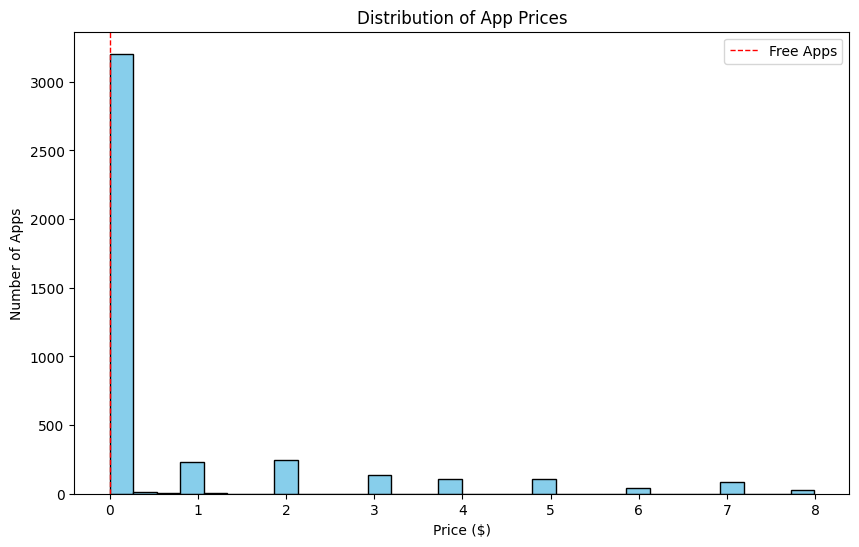

<Figure size 1000x600 with 0 Axes>

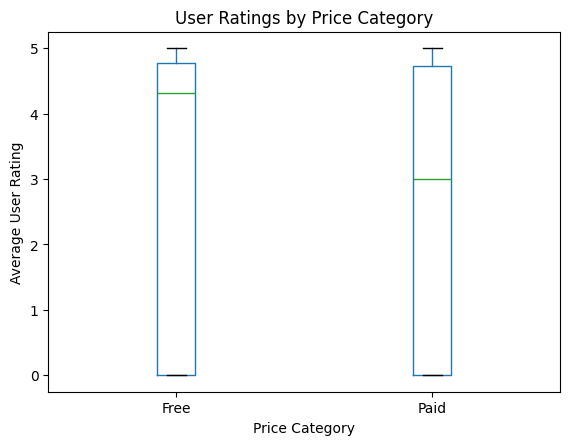

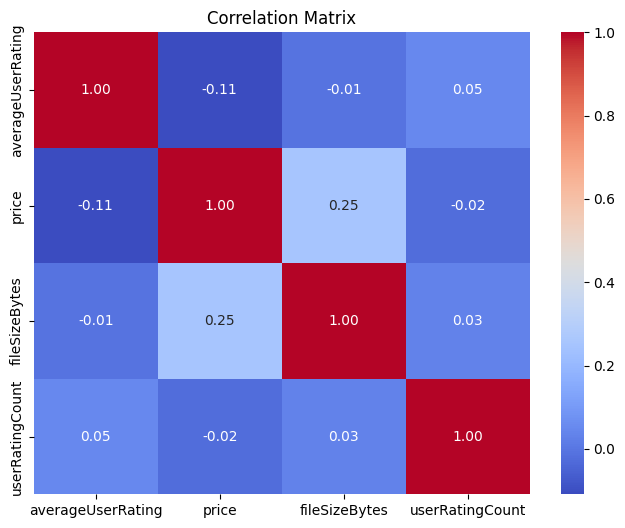

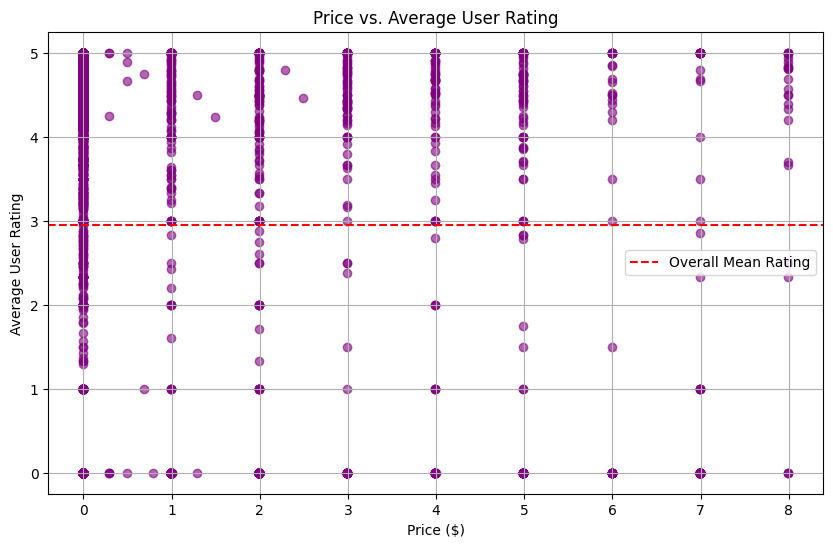

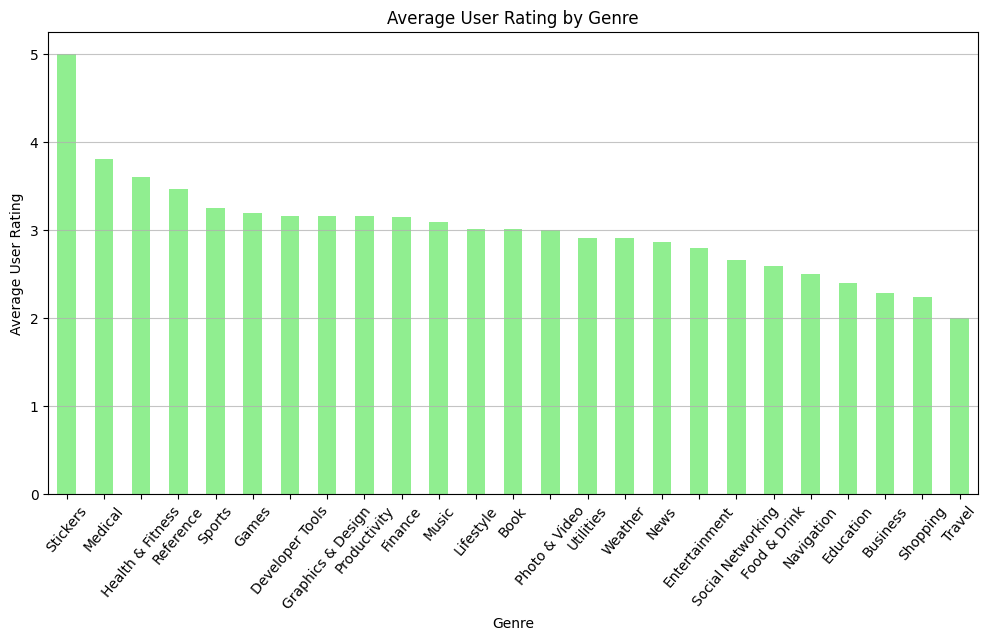

In [8]:
#1. Distribution of app prices
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of App Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Apps')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label='Free Apps')  # Line indicating free apps
plt.legend()
plt.show()

#2. Boxplot for user ratings by price category
plt.figure(figsize=(10, 6))
data.boxplot(column='averageUserRating', by='price_category', grid=False)
plt.title('User Ratings by Price Category')
plt.suptitle('')  # Remove default title
plt.xlabel('Price Category')
plt.ylabel('Average User Rating')
plt.show()

# 3. Correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 4. Scatter plot for Price vs. Average User Rating
plt.figure(figsize=(10, 6))
plt.scatter(data['price'], data['averageUserRating'], alpha=0.6, color='purple') 
plt.title('Price vs. Average User Rating')
plt.xlabel('Price ($)')
plt.ylabel('Average User Rating')
plt.grid()
plt.axhline(y=mean_rating, color='red', linestyle='--', label='Overall Mean Rating')  #Overall mean rating
plt.legend()
plt.show()

# 5. Average ratings by genre
plt.figure(figsize=(12, 6))
genre_ratings.plot(kind='bar', color='lightgreen')
plt.title('Average User Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average User Rating')
plt.xticks(rotation=50)
plt.grid(axis='y', alpha=0.75)
plt.show()
